In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math

PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])

In [74]:
#
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
#multi index dataframe
#blocks of each day (keeping zone year month day and variating hour) 
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 17.80it/s]


In [75]:
# convert pd.DateFrame to np.array of type float and group by zone. mi_df to df_zone
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

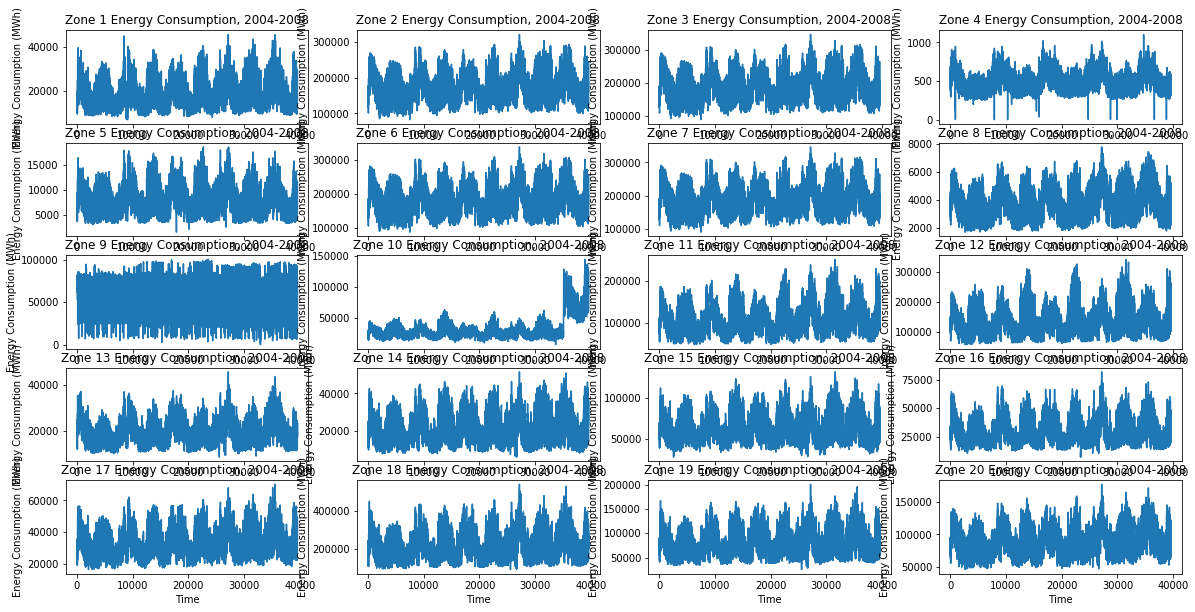

In [76]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [77]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pydot

In [152]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [153]:
# helper function to read data.

def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_dataset_nstep_bidir(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_dataset_nstep_test(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(0,len(dataset) - window_size - nstep - 1, window_size + nstep):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(200, activation='tanh', input_shape = (1, window_size), return_sequences=True)))
    vanilla_rnn.add(Dropout(rate = 0.2))
    vanilla_rnn.add(Bidirectional(LSTM(200,input_shape = (1, window_size), )))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

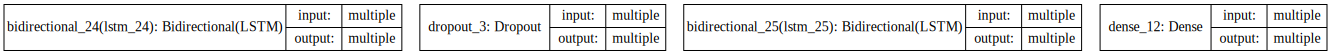

In [154]:
window_size, nstep =  24 * 7 * 32, 24 * 7 * 4
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [155]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 1000, verbose = 2, validation_split=0.15, callbacks=[es])


Train on 21769 samples, validate on 3842 samples
Epoch 1/100
 - 75s - loss: 0.0369 - val_loss: 0.0220
Epoch 2/100
 - 60s - loss: 0.0190 - val_loss: 0.0194
Epoch 3/100
 - 59s - loss: 0.0176 - val_loss: 0.0193
Epoch 4/100
 - 59s - loss: 0.0171 - val_loss: 0.0191
Epoch 5/100
 - 60s - loss: 0.0160 - val_loss: 0.0177
Epoch 6/100
 - 59s - loss: 0.0135 - val_loss: 0.0136
Epoch 7/100
 - 60s - loss: 0.0114 - val_loss: 0.0116
Epoch 8/100
 - 62s - loss: 0.0104 - val_loss: 0.0105
Epoch 9/100
 - 61s - loss: 0.0093 - val_loss: 0.0101
Epoch 10/100
 - 61s - loss: 0.0088 - val_loss: 0.0098
Epoch 11/100
 - 59s - loss: 0.0085 - val_loss: 0.0094
Epoch 12/100
 - 59s - loss: 0.0083 - val_loss: 0.0092
Epoch 13/100
 - 59s - loss: 0.0081 - val_loss: 0.0093
Epoch 14/100
 - 59s - loss: 0.0079 - val_loss: 0.0091
Epoch 15/100
 - 59s - loss: 0.0078 - val_loss: 0.0091
Epoch 16/100
 - 59s - loss: 0.0077 - val_loss: 0.0093
Epoch 17/100
 - 60s - loss: 0.0075 - val_loss: 0.0092
Epoch 18/100
 - 59s - loss: 0.0074 - val_l

In [156]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[:, 0], pred[:, 0]))
    return(score, pred)
#     return pred
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

# train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
# test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)


Training data error: 3170.39 MSE
Test data error: 3197.27 MSE


In [96]:
test_predict.shape

(5899, 672)

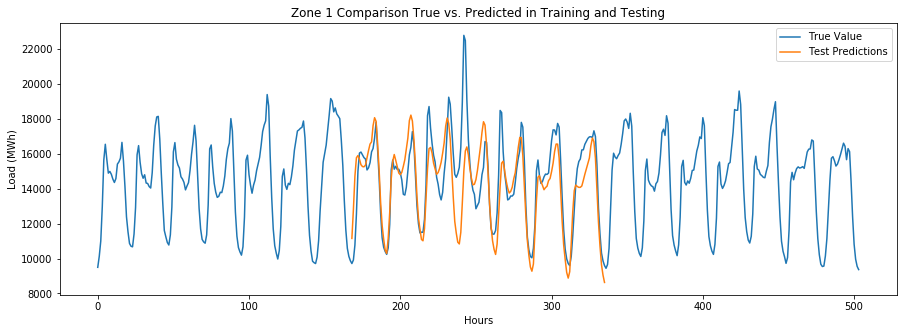

In [70]:
# Training predictions.
# train_predictions = np.empty_like(dataset)
train_predictions = np.zeros(train_predict.shape[0]*train_predict.shape[1]).reshape(train_predict.shape[0],train_predict.shape[1])
train_predictions[0:len(train_predict) + window_size + nstep, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
# test_predictions = np.zeros(test_predict[0].shape[0]*test_predict[0].shape[1]).reshape(test_predict[0].shape[0],test_predict[0].shape[1])
test_predictions[:, :] = np.nan

ws_2 = int(window_size/2)
j = 0
auxi = 0
for i in range(train_size,len(dataset) - window_size - nstep - 1, window_size + nstep):
    test_predictions[i + ws_2:i + ws_2 + nstep] = test_predict[j].reshape(nstep, 1)
    j += 1
    if j == 70:
        auxi = i
        break


# # Create the plot.
# plt.figure(figsize = (15, 5))
# plt.plot(normalizer.inverse_transform(dataset)[train_size  + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "True Value")
# # plt.plot(train_predictions, label = "Training Predictions")
# plt.plot(test_predictions[train_size + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "Test Predictions")
# plt.xlabel("Hours")
# plt.ylabel("Load (MWh)")
# plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
# plt.legend()
# plt.show()
i = 7
n = window_size + nstep
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [71]:

import os
test_predictions=test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep].reshape(1, -1)
print(test_predictions)
path = r'../../Data/bidirectionallstm_predictor_168h_window672_37708_38212.csv'
if not os.path.exists(path):
    np.savetxt(path, (test_predictions), delimiter=',')

In [174]:
test_predictions=test_predict[600].reshape(1, -1)
print(test_predictions)
path = r'../../Data/ari4.csv'
if not os.path.exists(path):
    np.savetxt(path, (test_predictions), delimiter=',')

[[12706.001  13902.869  15109.707  16122.715  16413.574  16478.518
  16093.8955 15206.771  14521.22   14343.233  14487.027  14756.709
  15780.472  16767.662  17223.467  17530.28   17295.543  16570.852
  15282.926  13629.313  12478.592  11734.473  11165.372  11732.291
  12520.427  13618.551  14880.027  16093.732  16620.564  16706.668
  15961.848  15475.658  14862.5625 14243.985  14580.351  15040.92
  15740.649  16670.693  17264.977  17478.525  17412.777  16482.393
  15027.131  13672.364  12367.869  11461.759  11225.389  11456.921
  12287.543  13659.246  14787.192  16023.062  16535.057  16413.047
  15985.579  15163.587  14585.414  14390.074  14583.987  14842.397
  15710.832  16524.732  17367.197  17476.791  17450.44   16424.756
  15051.097  13471.286  12187.409  11672.922  11076.119  11624.604
  12472.677  13684.01   14726.842  15696.729  16405.543  16477.777
  15803.419  15336.438  14632.721  14618.852  14577.909  14777.4795
  15761.457  16683.322  17339.305  17504.04   17311.639  16366

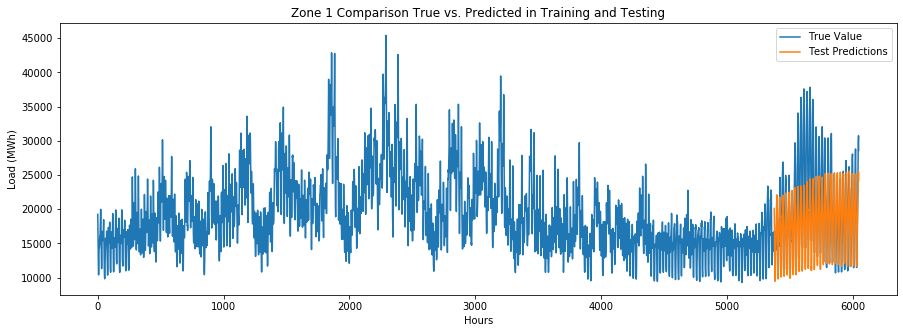

In [167]:
# Create the plot.
plt.figure(figsize = (15, 5))
i = 1600
plt.plot(normalizer.inverse_transform(dataset)[train_size+i:train_size + window_size + nstep + i], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(np.concatenate((np.array([np.nan] * (window_size)), test_predict[i])), label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

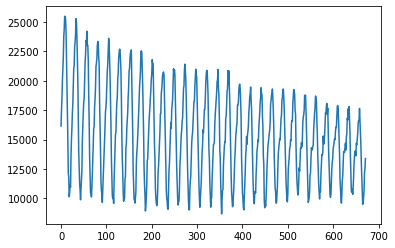

In [105]:
plt.plot(test_predict[100])

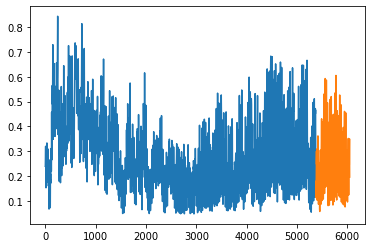

In [158]:
plt.plot(train_X[1, :, :].reshape(-1, 1))
plt.plot(np.concatenate(([np.nan]*window_size, train_Y[0])))

In [159]:
window_size, nstep =  24 * 7 * 32, 24 * 7 * 4
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)


In [147]:
train_X.shape


(25611, 5376)

In [148]:
window_size

5376

In [149]:
nstep

672

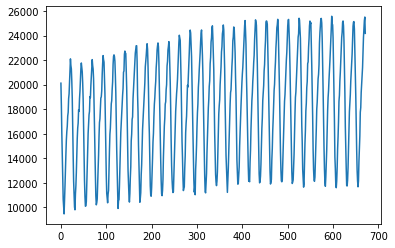

In [169]:
plt.plot(test_predict[i])